## This is the notebook where I am fixing the sliding window approach

https://www.ncedc.org/ncedc/catalog-search.html

In [1]:
import warnings
warnings.filterwarnings('ignore') # ignore warnings
import numpy as np
import matplotlib as mpl
from matplotlib.pyplot import *
%matplotlib inline 
# plot inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png') # output figure in png format
import matplotlib.pyplot as plt
from obspy.core.utcdatetime import UTCDateTime #convert time to UTC time
mpl.rcParams['figure.dpi']= 500 # setup the figure resolution


# add the google drive directory into path
#from google.colab import drive
#drive.mount('/content/drive')
#path = '/content/drive/MyDrive/traffic_light_project/'
path = 'C:/Users/yair_/Documents/Traffic Light Project/'

In [2]:
qfault=np.loadtxt(path+'qfaults.txt')
# fault data from USGS website

In [3]:
year = []
lat = []
lon = []
dep = []
mag = []
evid = []
time_utc = []
time_year = []
fid = open(path+'mtj84pres.txt')
# read in the header
line = fid.readline()
print(line)
line = fid.readline()
print(line)

#read in event lines
num = 0
for line in fid:
    num = num + 1
    if num%1000 == 0:
        print(num)
    info = line.split()
    if len(info) <2:
        continue
    iyear = int(info[0][:4])
    ilat = float(info[2])
    ilon = float(info[3])
    idep = float(info[4])
    imag = float(info[5])
    ievid = int(info[-1])
    itime_utc = float(UTCDateTime(info[0]+'T'+info[1]))
    itime_year = iyear + (itime_utc-float(UTCDateTime(iyear,1,1)))/(float(UTCDateTime(iyear+1,1,1)-float(UTCDateTime(iyear,1,1))))

    year.append(iyear)
    lat.append(ilat)
    lon.append(ilon)
    dep.append(idep)
    mag.append(imag)
    evid.append(ievid)
    time_utc.append(itime_utc)
    time_year.append(itime_year)
  
#convert list into array
year = np.asarray(year)
lat = np.asarray(lat)
lon = np.asarray(lon)
dep = np.asarray(dep)
mag = np.asarray(mag)
evid = np.asarray(evid)
time_utc = np.asarray(time_utc)
time_year = np.asarray(time_year)

Date       Time              Lat        Lon   Depth   Mag Magt  Nst Gap  Clo  RMS  SRC   Event ID

-------------------------------------------------------------------------------------------------

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000


In [4]:
def convert(lat_all,lon_all,lat0,lon0,azimuth,mdist,halfwidth=10):
    # Input:
    # lat_all: latitude of all points
    # lon_all: longitude of all points
    # lat0, lon0 : starting point location for the projection
    # azimuth: azimuth of the projection
    # mdist: distance along the projection from lat0,lon0
    # halfwidth: half width from the projection line
    
    # Output:
    # dist_along_all, dist_norm_all: distance along and normal to the projection
    # mlat, mlon: end point of the projection
    # box_coor: coordinates of the selected polygon
    import math
    x_all = (lon_all-lon0)*40000*np.cos((lat_all+lat0)*np.pi/360)/360
    y_all = (lat_all-lat0)*40000/360
    
    x0=0
    y0=0
    x1=np.sin(azimuth/180*np.pi)
    y1=np.cos(azimuth/180*np.pi)
    
    dist_all=np.sqrt(x_all**2+y_all**2)
    
    dist_along_all=x_all*x1+y_all*y1
    dist_norm_all=x_all*y1-y_all*x1
    
    mlat=mdist*y1*360/40000+lat0
    mlon=mdist*x1*360/40000/np.cos((mlat+lat0)*np.pi/360)+lon0
    
    blat1=lat0+halfwidth*x1*360/40000
    blon1=lon0-halfwidth*y1*360/40000/np.cos((mlat+lat0)*np.pi/360)
    blat2=lat0-halfwidth*x1*360/40000
    blon2=lon0+halfwidth*y1*360/40000/np.cos((mlat+lat0)*np.pi/360)
    blat3=mlat-halfwidth*x1*360/40000
    blon3=mlon+halfwidth*y1*360/40000/np.cos((mlat+lat0)*np.pi/360)
    blat4=mlat+halfwidth*x1*360/40000
    blon4=mlon-halfwidth*y1*360/40000/np.cos((mlat+lat0)*np.pi/360)
    
    
    box_coor=np.asarray([[blat1,blon1],[blat2,blon2],[blat3,blon3],[blat4,blon4],[blat1,blon1]])
    return dist_along_all,dist_norm_all,mlat,mlon,box_coor

In [24]:
#
lat0_proj= 40.4
lon0_proj=-125
azimuth_proj=97
mdist_proj=70

dist_along_proj,dist_norm_proj,mlat_proj,mlon_proj,box_coor_proj= \
    convert(lat,lon,lat0_proj,lon0_proj,azimuth_proj,mdist_proj,halfwidth=7)

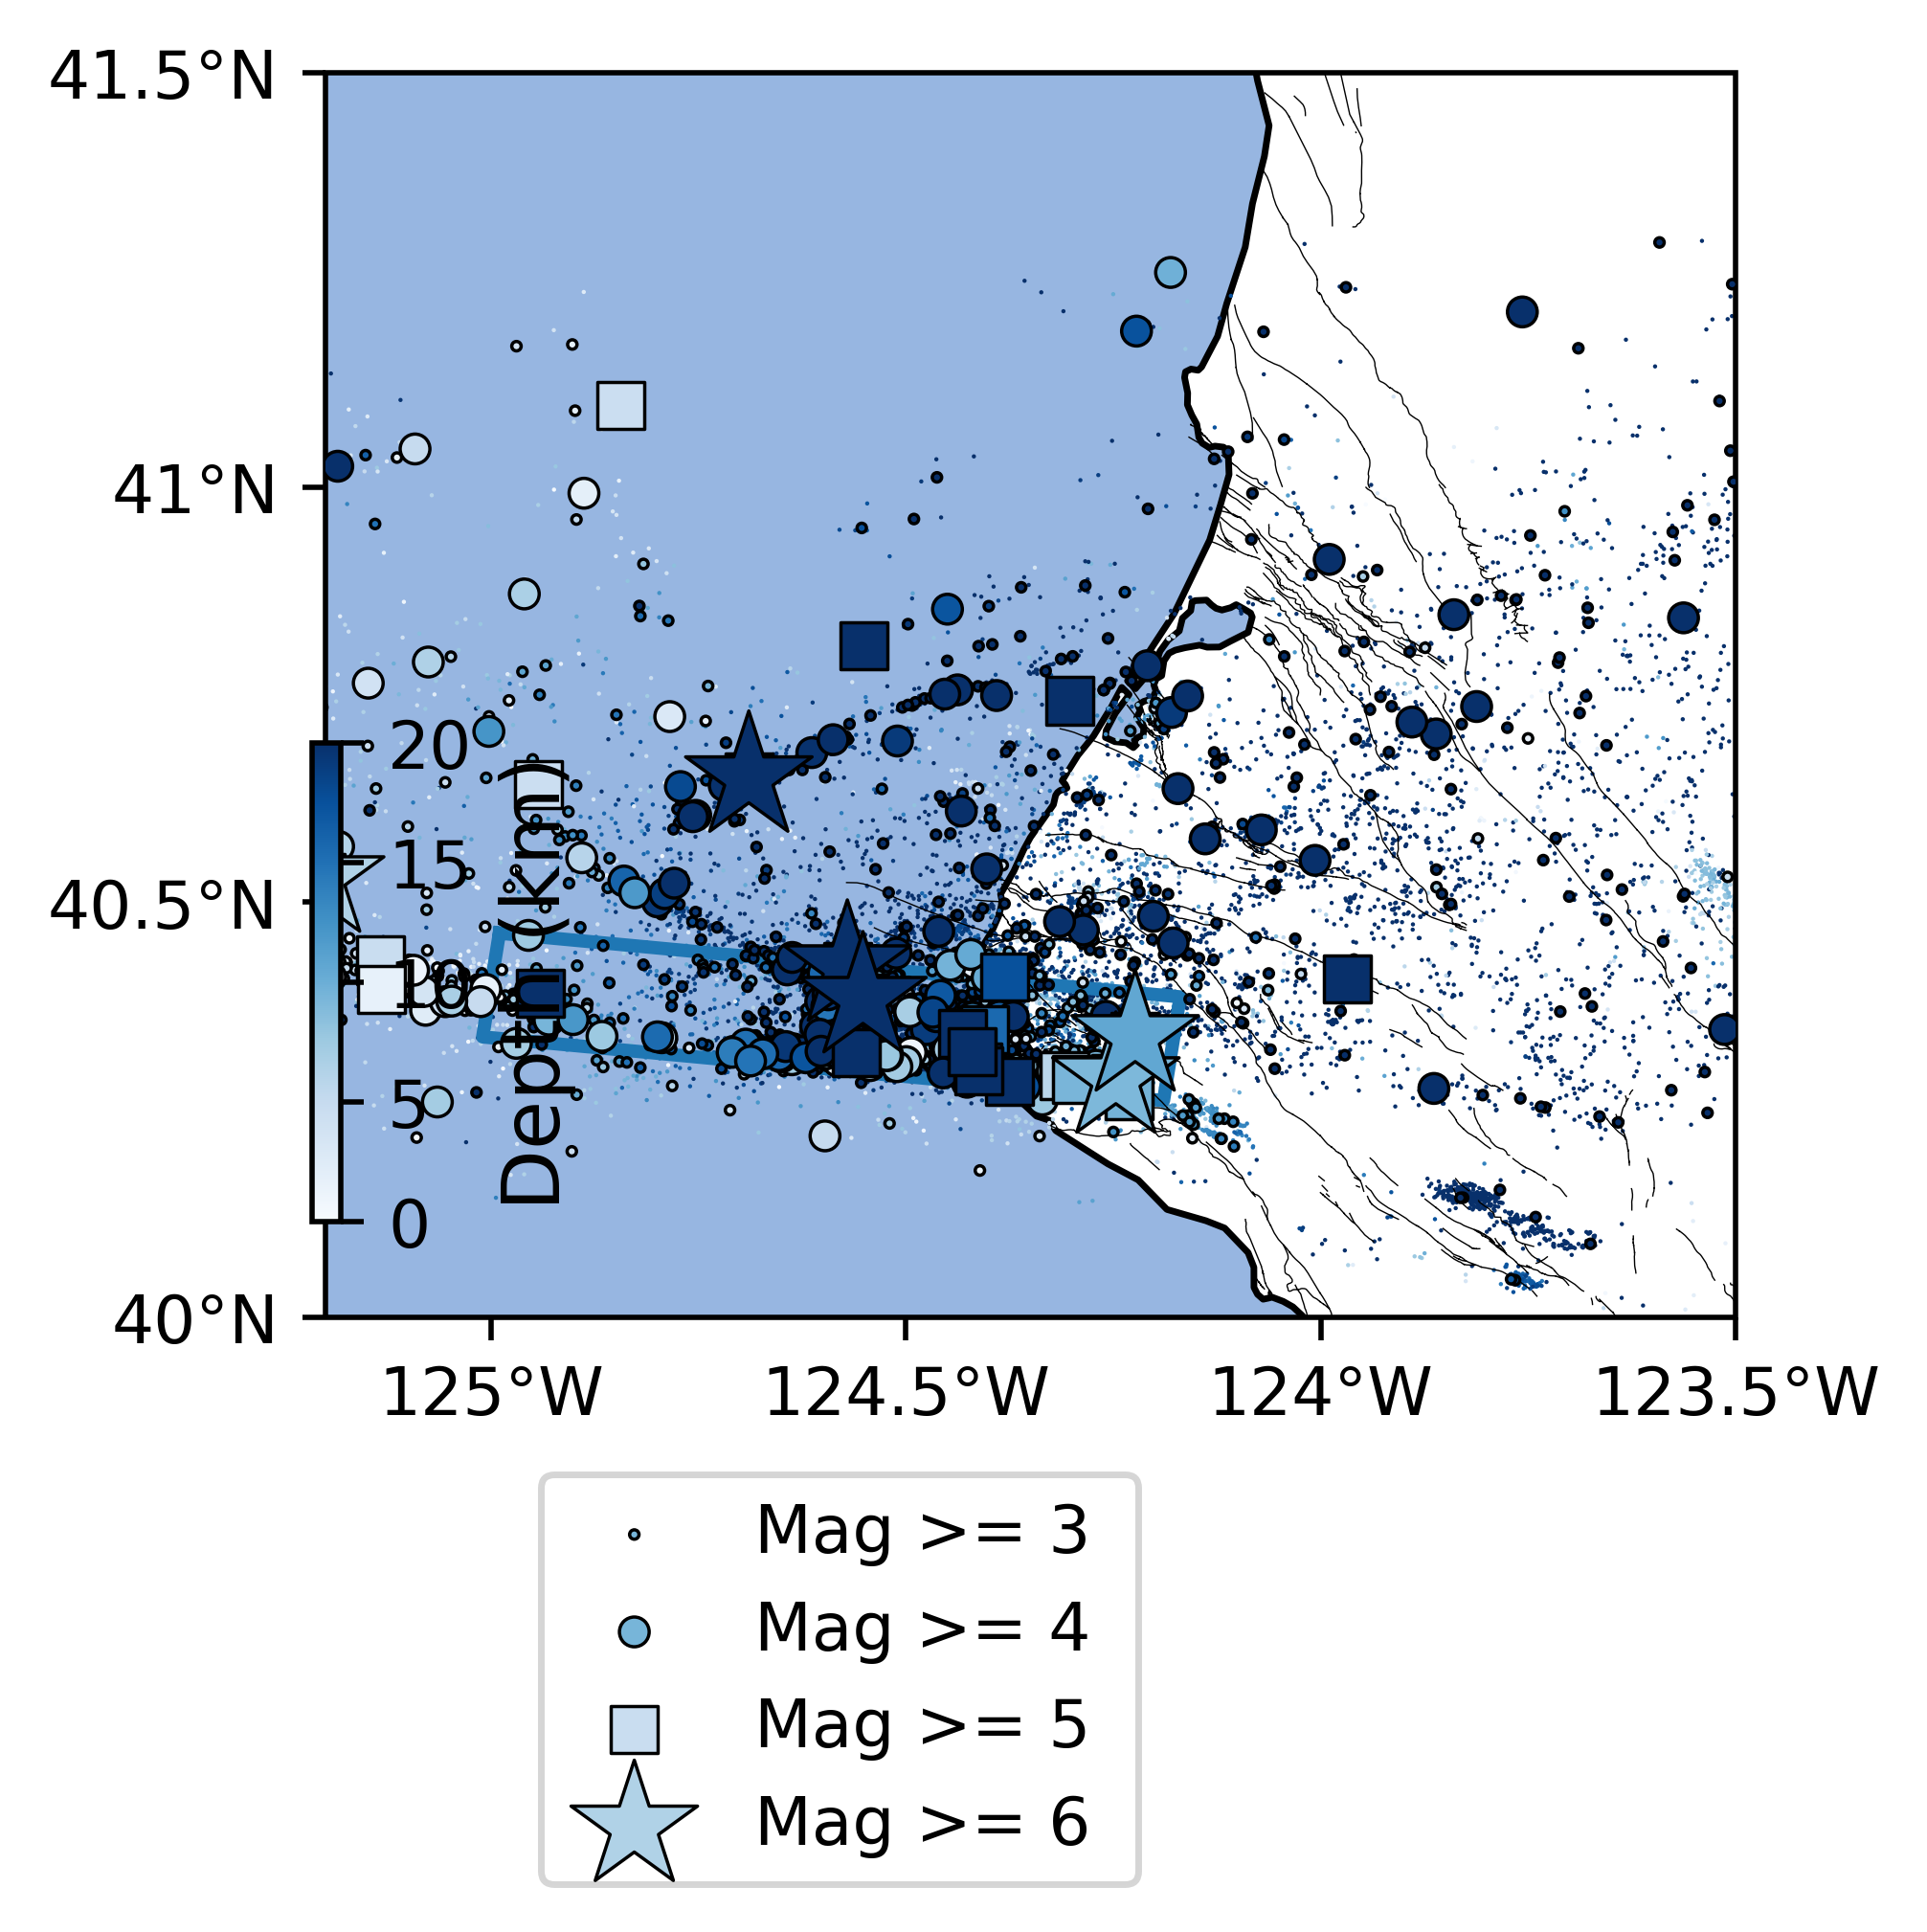

In [25]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

lake_10m = cfeature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='k',
                                         linewidth=0.5,
                                        facecolor=cfeature.COLORS['water'])

provinces_10m = cfeature.NaturalEarthFeature('cultural',
                                             'admin_1_states_provinces_lines',
                                             '10m',
                                             facecolor='none')
oceans_10m = cfeature.NaturalEarthFeature('physical',
                                             'ocean',
                                             '10m',
                                             facecolor=cfeature.COLORS['water'])

fig=plt.figure()
ax = fig.add_axes([0, 0, 1, 0.65], projection=ccrs.PlateCarree())

ax.add_feature(lake_10m)
ax.add_feature(oceans_10m)
ax.add_feature(provinces_10m)
ax.add_feature(cfeature.BORDERS)
ax.coastlines('10m')

index = np.where(mag>=3)
ax.scatter(lon[index],lat[index],marker='o',s=2,lw=0.5,cmap='Blues',edgecolors='k',c=dep[index],zorder=5, \
              vmin=0,vmax=20,label='Mag >= 3')
index = np.where(mag>=4)
ax.scatter(lon[index],lat[index],marker='o',s=20,lw=0.5,cmap='Blues',edgecolors='k',c=dep[index],zorder=5, \
              vmin=0,vmax=20,label='Mag >= 4 ')
index = np.where(mag>=5)
ax.scatter(lon[index],lat[index],marker='s',s=50,lw=0.5,cmap='Blues',edgecolors='k',c=dep[index],zorder=5, \
              vmin=0,vmax=20,label='Mag >= 5 ')
index = np.where(mag>=6)
ax.scatter(lon[index],lat[index],marker='*',s=400,lw=0.5,cmap='Blues',edgecolors='k',c=dep[index],zorder=5, \
              vmin=0,vmax=20,label='Mag >= 6 ')
im = ax.scatter(lon,lat,c=dep,s=0.4,edgecolors='none',cmap='Blues', \
               vmin=0,vmax=20)
ax.legend(bbox_to_anchor=(0.6,-0.1))

ax.set_yticks(np.arange(40,42+0.1,0.5))
ax.set_xticks(np.arange(-125,-122+0.1,0.5))
ax.plot(qfault[:,1],qfault[:,0],lw=0.2,c='k',zorder=3)


ax.plot(box_coor_proj[:,1],box_coor_proj[:,0],lw=2)
lon_formatter = LongitudeFormatter(number_format='g',dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='g')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_ylim(40,41.5)
ax.set_xlim(-125.2,-123.5)

cax1 = fig.add_axes([0.25, 0.05, 0.01, 0.25])
cbar=fig.colorbar(im,cax=cax1,fraction=0.04, pad=0.03,
                  label='Depth (km)',ticks=[0,5,10,15,20])
cbar.set_label(label='Depth (km)',fontsize=12)

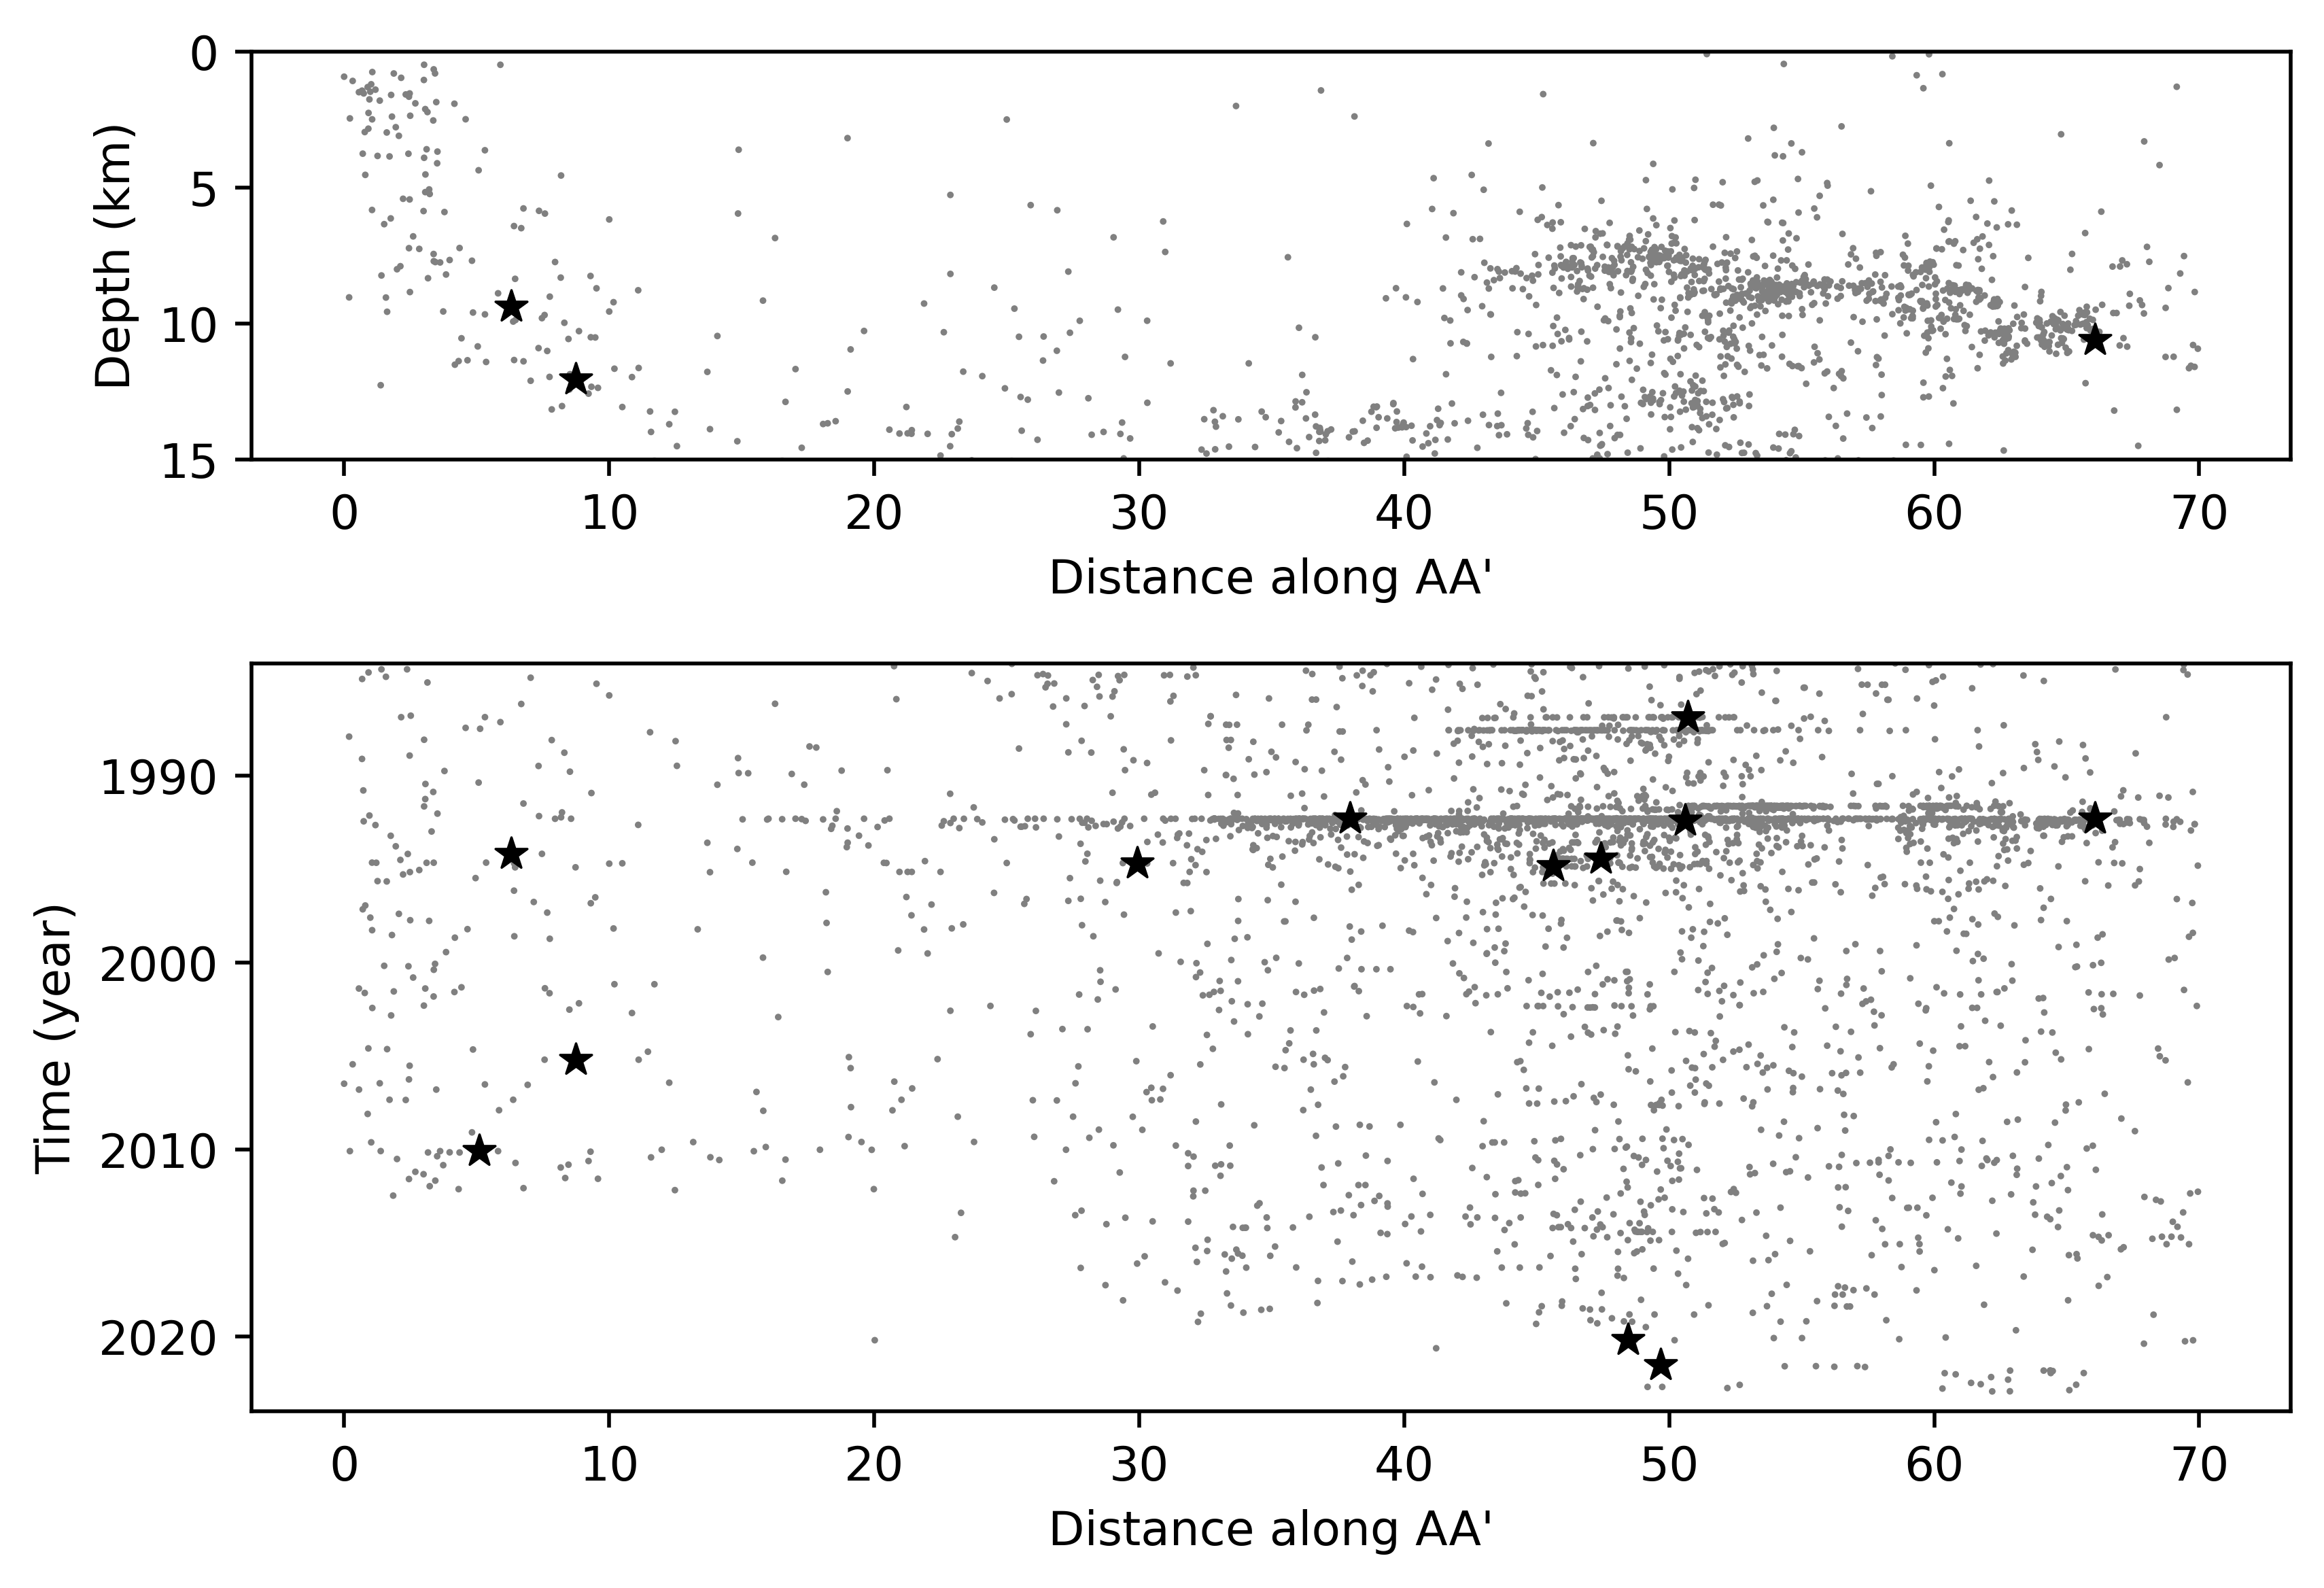

In [7]:
fig = plt.figure()
ax = fig.add_axes([0, 0.7, 1, 0.3])
index = np.where((dist_along_proj<mdist_proj)&(dist_along_proj>0)&(dist_norm_proj<5)&(dist_norm_proj>-5))[0]
ax.scatter(dist_along_proj[index],dep[index],c='gray',s=2,edgecolors='none')
index_M = np.where((dist_along_proj<mdist_proj)&(dist_along_proj>0)&
                   (dist_norm_proj<5)&(dist_norm_proj>-5)&(mag>=4.5))[0]
ax.scatter(dist_along_proj[index_M],dep[index_M],c='k',s=50,edgecolors='k',lw=0.5,marker='*')
ax.set_ylim(15,0)
ax.set_xlabel("Distance along AA'")
ax.set_ylabel("Depth (km)")

ax = fig.add_axes([0, 0, 1, 0.55])
index = np.where((dist_along_proj<mdist_proj)&(dist_along_proj>0)&(dist_norm_proj<5)&(dist_norm_proj>-5))[0]
ax.scatter(dist_along_proj[index],time_year[index],c='gray',s=2,edgecolors='none')
index_M = np.where((dist_along_proj<mdist_proj)&(dist_along_proj>0)&
                   (dist_norm_proj<5)&(dist_norm_proj>-5)&(mag>=4.5))[0]
ax.scatter(dist_along_proj[index_M],time_year[index_M],c='k',s=50,edgecolors='k',lw=0.5,marker='*')
ax.set_ylim(2024,1984)
ax.set_xlabel("Distance along AA'")
ax.set_ylabel("Time (year)")

plt.show()

In [8]:
def calc_Mc_b(mag,plot=0):
    nNumberMagnitude=np.floor(mag.max()*10)+1
    xx=np.linspace(np.floor(mag.min()*10)/10,mag.max(),int((np.floor(mag.max()*10)/10-
                                                            np.floor(mag.min()*10)/10)*10)+1)
    vhist,vMagBins=np.histogram(mag,bins=xx)
    iMc = np.where(vhist==vhist.max())[0][-1]
    fMc=vMagBins[iMc]
    hist = vhist[iMc:][::-1]
    bins = vMagBins[iMc:][::-1]
    cum_hist = hist.cumsum()
    log_cum_sum = np.log10(cum_hist)
    bins = bins[1:]
    b,a = np.polyfit(bins, log_cum_sum, 1)
    if plot==1:
        plt.figure()
        plt.subplot(211)
        plt.bar(vMagBins[:-1]+0.05,vhist,0.1)
        plt.axvline(x=fMc,c='r',lw=2)
        plt.title('Mc:'+ "{:.2f}".format(fMc)+'  '+'b value:'+  "{:.2f}".format(-b))
        plt.xlim(-1,8)
        plt.ylabel('Event number')
        plt.subplot(212)
        plt.plot(bins,np.log10(cum_hist))
        plt.plot(bins,a + b*bins)
        plt.xlim(-1,8)
        plt.xlabel('Magnitude')
        plt.ylabel('log10(CDF)')
        plt.show()
        
    return fMc, a, -b

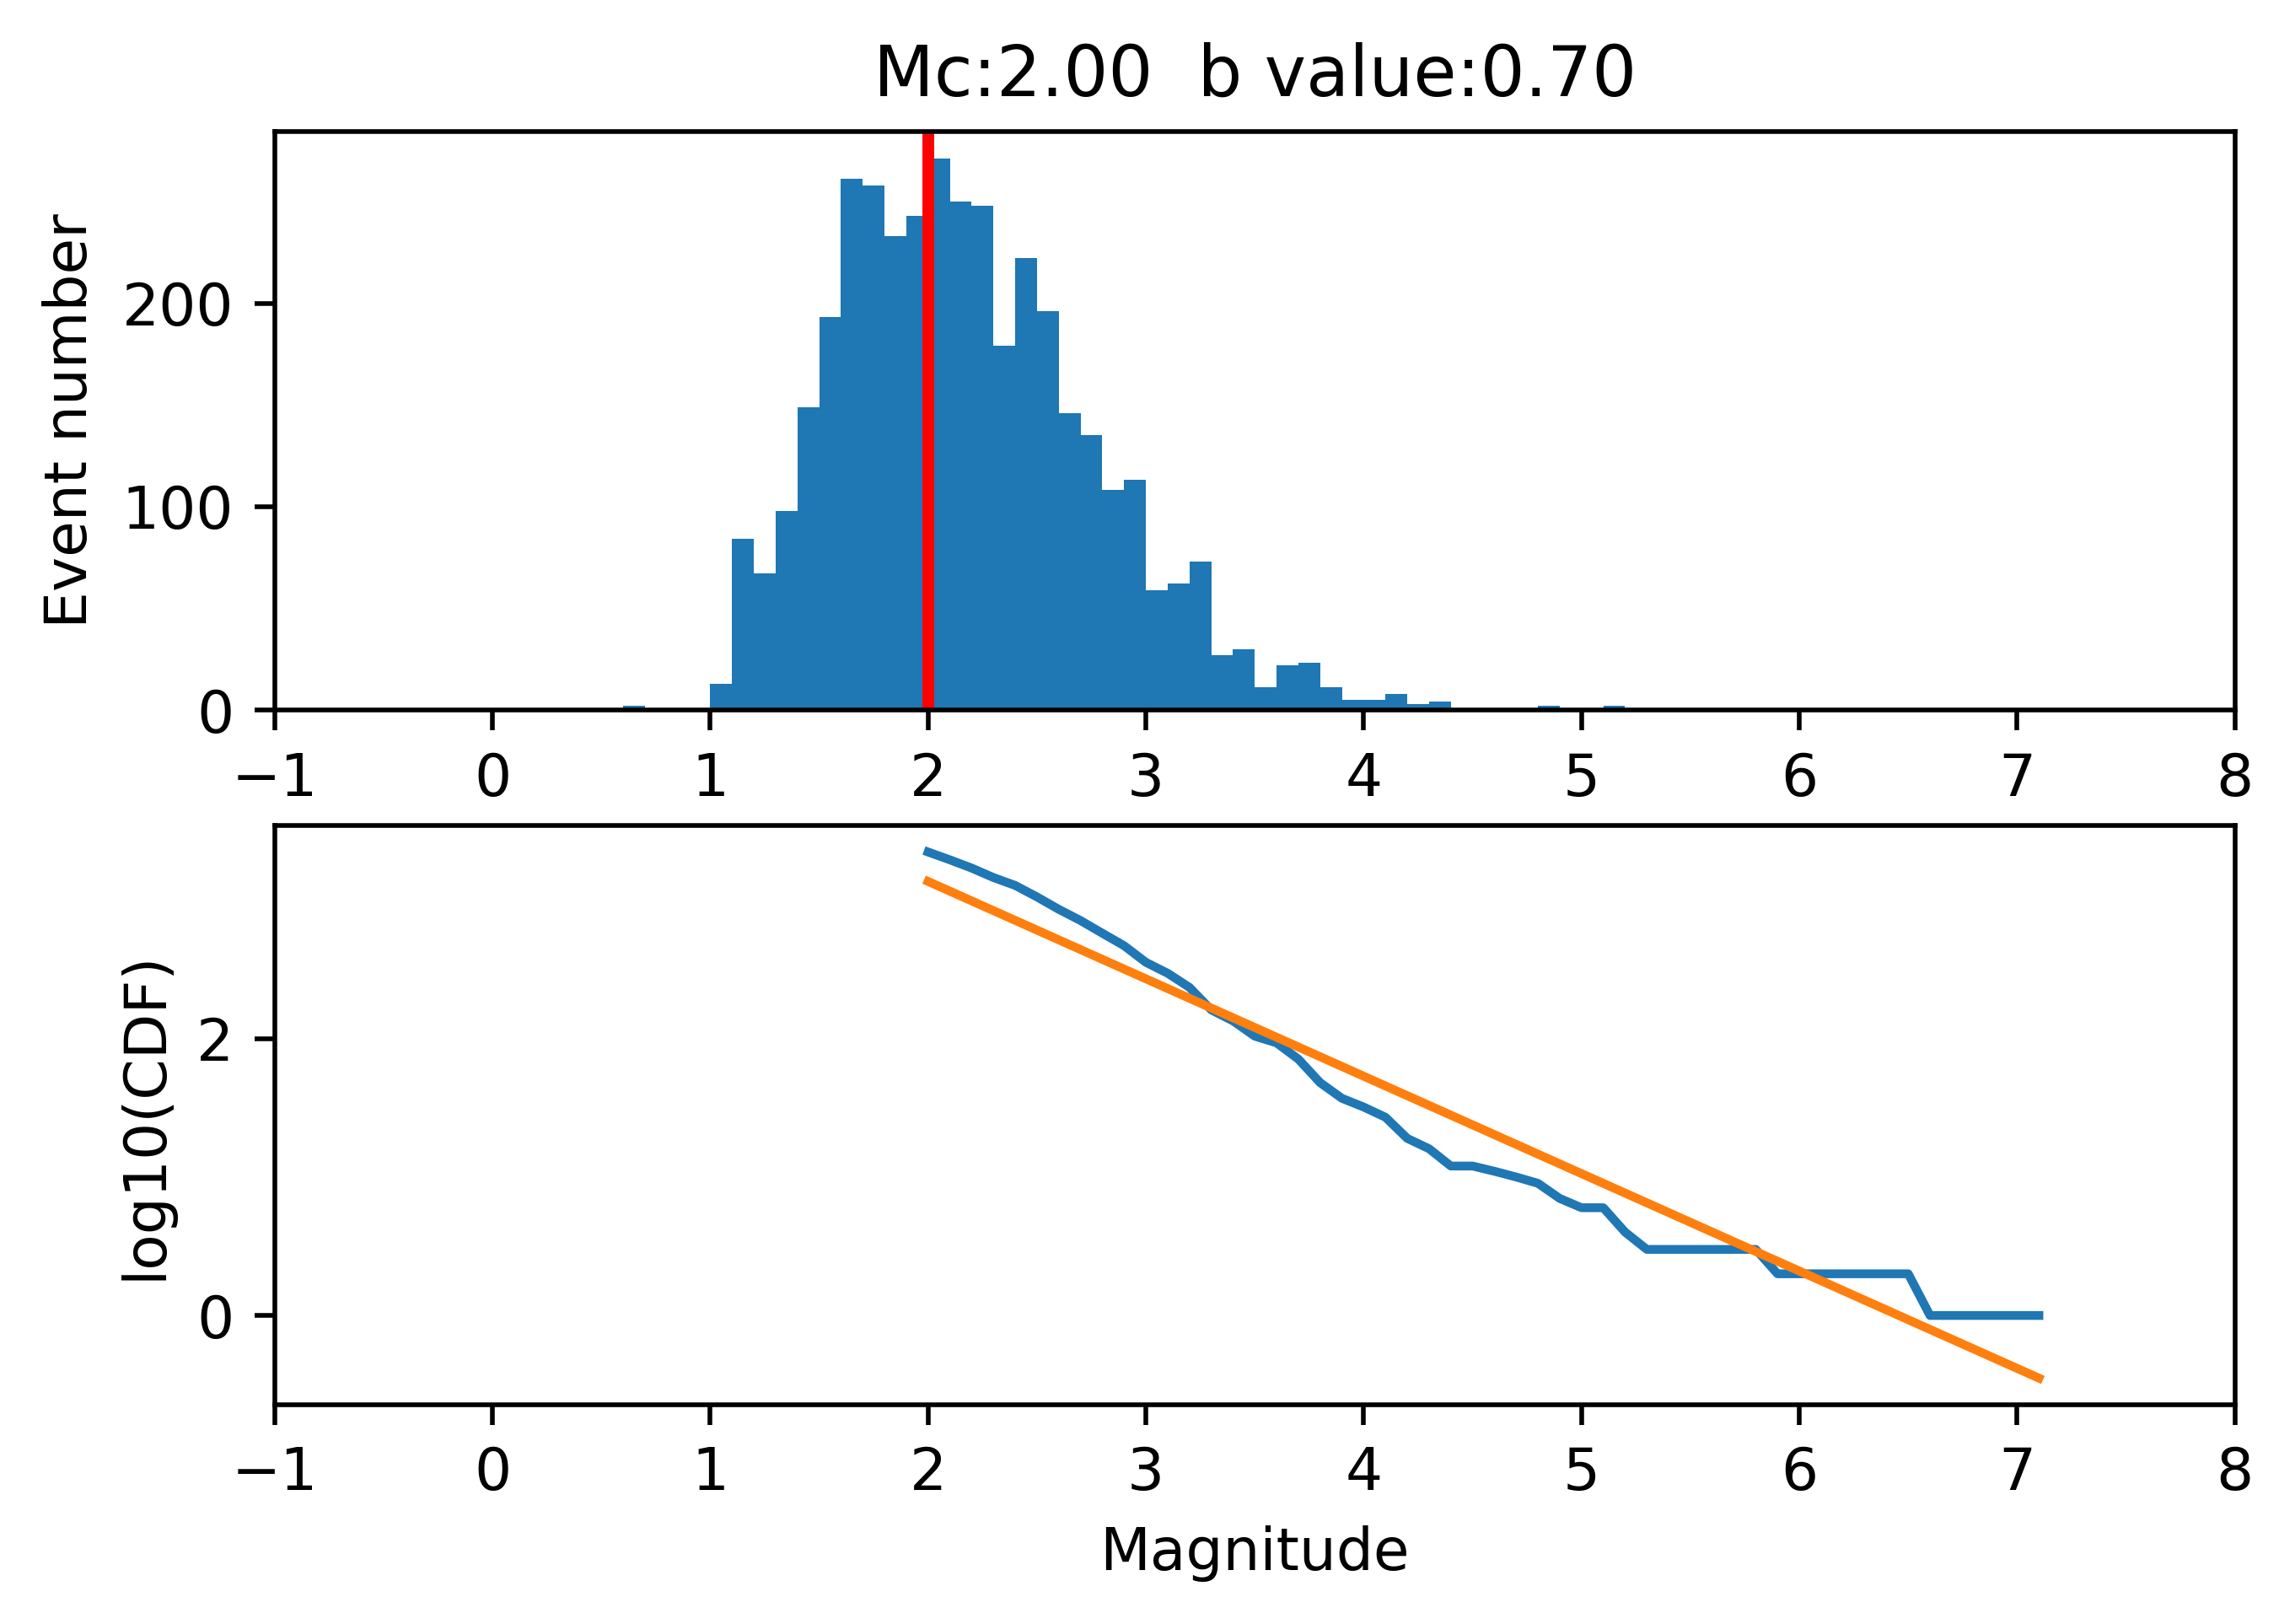

(2.0, 4.5411756686035476, 0.70333502526283409)

In [9]:
index = np.where((dist_along_proj<mdist_proj)&(dist_along_proj>0)&(dist_norm_proj<5)&(dist_norm_proj>-5))[0]

calc_Mc_b(mag[index],plot=1)

In [10]:
def addbVal_slide(arrayName,bval,dates,firstEQ=0,lastEQ=1,plot=0): #adds b values to given array and can also plot
    if plot==0:
        arrayName.append(bval)
    
    elif plot==1:
        xrange = len(arrayName)
        x = dates #startyear was what changed
        
        print(len(x),len(arrayName))
        
        a,b = np.polyfit(x,arrayName,1)
        
        bMed = np.median(arrayName)
        YLBuffer = 0.1 * bMed
            
        plt.axhspan(0,bMed-YLBuffer,0,xrange,color="red",alpha=0.5)
        plt.axhspan(bMed-YLBuffer,bMed+YLBuffer,0,xrange,color="yellow",alpha=0.5)
        plt.axhspan(bMed+YLBuffer,np.max(arrayName)+0.5,0,xrange,color="green",alpha=0.5)
        #arbitrary range for colors for now, need to read up more on how to choose these.
        
        plt.axhline(y = bMed, color = 'black', linestyle = '--',label=f"Median ({np.around(bMed,3)})")
        plt.plot(x,arrayName,'b-',label="b-value trend")
        #plt.plot(x,a*x+b,'r',label=f"Best fit line")
        
        #TODO: convert event id to year and mark on x-axis
        
        plt.xlabel(f"Year")
        plt.ylabel('b-value')
        plt.legend()
        plt.ylim(0,np.max(arrayName)+0.5)
        #plt.ylim(0,2)
        plt.xticks(np.arange(np.around(firstEQ), np.around(lastEQ), step=2))  # Set label locations.
        #plt.xticks([0,1,2],[firstEQ,"middle",lastEQ])
        #plt.rc('xtick', labelsize=3)

1995
(array([   1,    2,    3, ..., 7547, 7548, 7549], dtype=int64),)
[   1    2    3 ..., 7547 7548 7549]
4014
end of loop, steps: 3015 out of 4014 needed; date of last eq: 1995.000358544576; last b: 0.953347937629946
x range: 1986.7367441508118 to 1994.999236719305; array lengths: (3016, 3016)
3016 3016


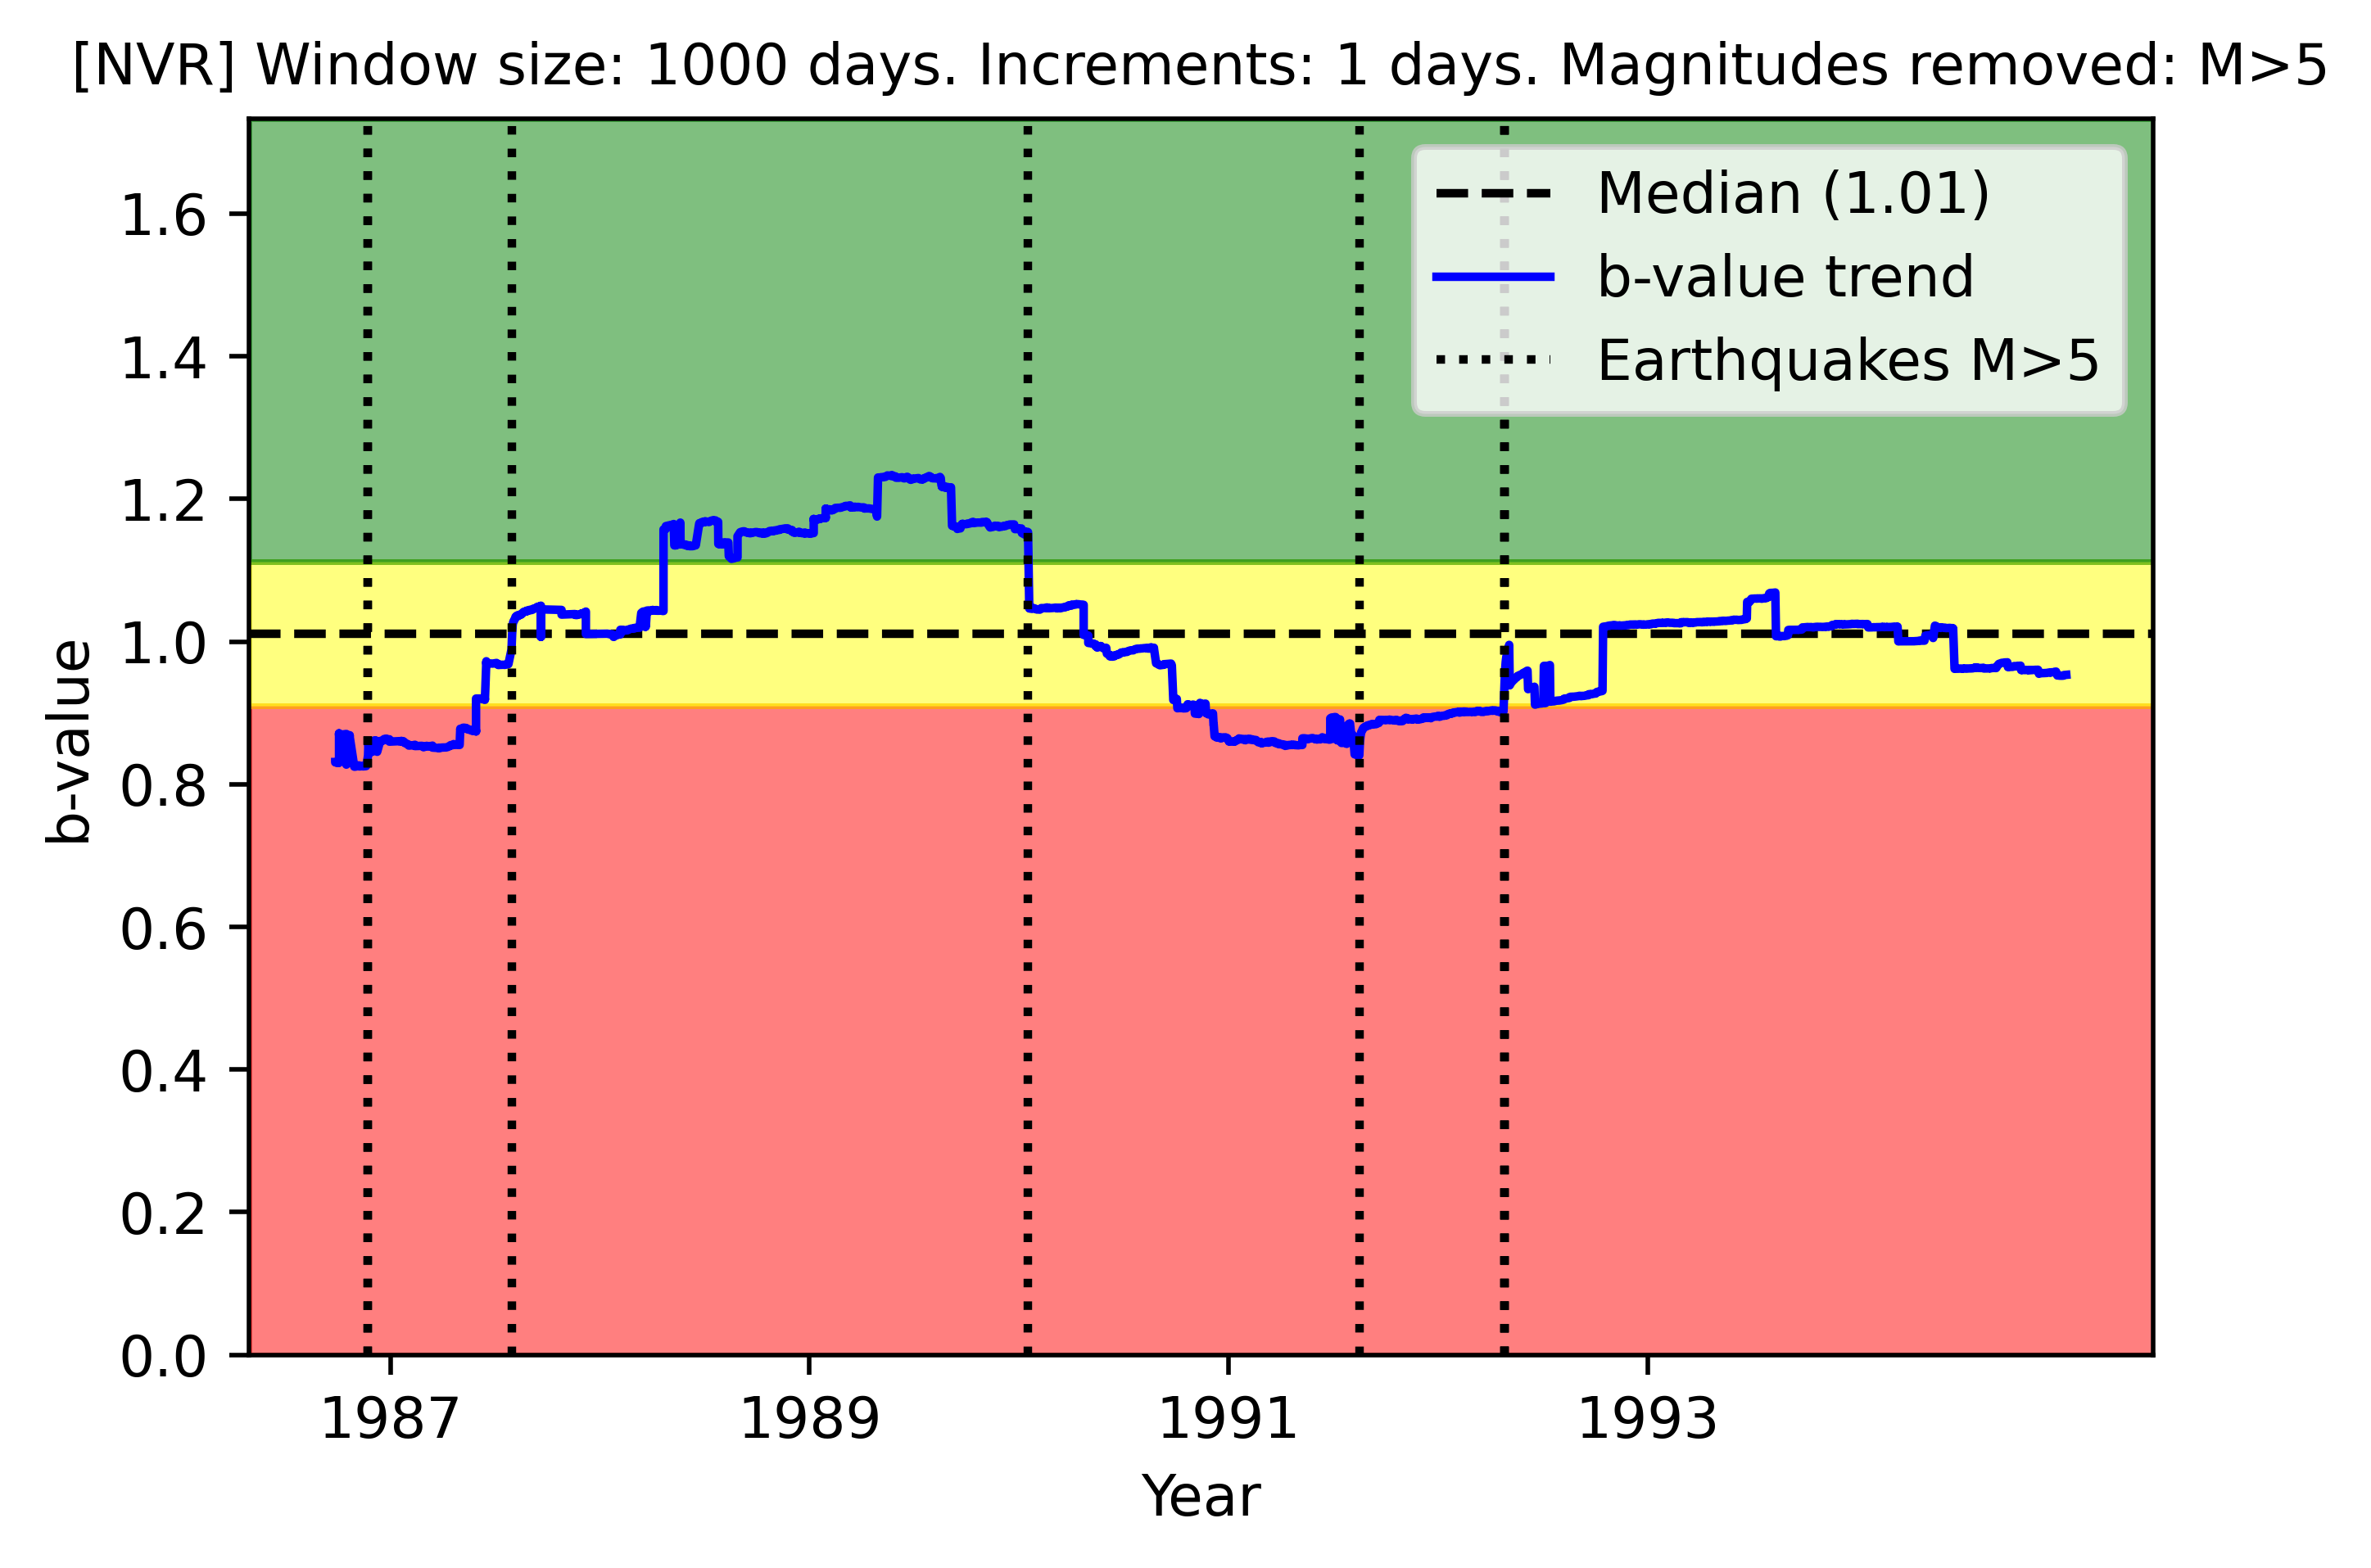

In [11]:
slideAtt = []
bDates = []

timeStart = np.min(time_year)
timeEnd = 1995#np.max(time_year) #or custom decimal year dates
print(timeEnd)
timeTotal = timeEnd - timeStart

areaParams = (dist_along_proj<70)&(dist_along_proj>0)&(dist_norm_proj<7)&(dist_norm_proj>-7)
timeParams = (time_year>timeStart)&(time_year<timeEnd)

bigMag = 5
#data = np.where(areaParams&timeParams)
data = np.where(timeParams&(mag<bigMag))
print(data)
index = data[0]
print(index)

## make a map shwing the location of all the selected events

windowSize = 1000 #in days
wsYears = windowSize / 365
inc = 1 #time increment per loop in days
incYears = inc / 365
steps = int(timeTotal/incYears)

print(steps)

for i in range(steps):
    ## make sure that the index list is unchanged
    w = 0
    wStart = timeStart + incYears * i
    wEnd = wStart + wsYears
    wParams = (time_year[index]>wStart)&(time_year[index]<wEnd)
    wIndices = np.where(wParams)[0]
    
    if len(wIndices) > 0:
        w = index[wIndices] # filter 'w' by 'wParams'
        bDates.append(time_year[w[-1]])  # append last event date in 'w'. Provided by ChatGPT
#     indexlist = []
#     for i, evid in enumerate(index):
#         if time_year[evid] > wStart:
#             if time_year[evid] < wEnd:
#                 indexlist.append(evid)
    # print(wStart,wEnd,w,indexlist)
    # print(wStart,wEnd,w,time_year[w])
    
    
    
    # bDates.append(wEnd)
    # bDates.append(time_year[w[len(w)-1]])
    # bDates.append(time_year[indexlist[len(indexlist)-1]])
    
    bW = calc_Mc_b(mag[w])[2]
    #bW = calc_Mc_b(mag[indexlist])[2]
    addbVal_slide(slideAtt,bW,bDates)
    #print(wStart,wEnd,len(w),bW,time_year[w[0]],time_year[w[len(w)-1]])
    #print(wStart,wEnd,len(indexlist),bW,time_year[indexlist[0]],time_year[indexlist[len(indexlist)-1]])
    
    #if i%250 == 0:
        #print(i,wEnd)
        
    if wEnd >= timeEnd:
        print(f"end of loop, steps: {i} out of {steps} needed; date of last eq: {wEnd}; last b: {bW}")
        xMin = np.min(bDates)
        xMax = np.max(bDates)
        print(f"x range: {xMin} to {xMax}; array lengths: {len(slideAtt),len(bDates)}")
        addbVal_slide(slideAtt,bW,bDates,xMin,xMax,1)
        break
        

bigEqs = np.where(areaParams&timeParams&(mag>bigMag))
bigDates = time_year[bigEqs]

for x in bigDates:
    if x == min(bigDates):
        plt.axvline(x, color='black', linestyle=':',label=f'Earthquakes M>{bigMag}')
    plt.axvline(x, color='black', linestyle=':')

#plt.axvline(x = 2018.004, color='red', linestyle='--', label='2018 Berkeley earthquake (M4.4)')
#plt.axvline(x = 2011.8014, color='purple', linestyle='--', label='2011 Berkeley earthquake swarm')
#plt.axvline(x = 2007.5493, color='yellow', linestyle='--', label='2007 Oakland Hills earthquake (M4.2)')
#plt.axvline(x = 1989.7932, color='gray', linestyle='--', label='1989 Loma Prieta earthquake (M7.0)')
plt.title(f"[NVR] Window size: {windowSize} days. Increments: {inc} days. Magnitudes removed: M>{bigMag}",fontsize=10)
plt.legend()

In [12]:
print(time_year[455])

1985.00438211


5171 [    5     6    13 ..., 15713 15714 15719]
end of loop, steps: 5071; date of last eq: 15719; last b: 0.5496154645928226
x range: 1985.1493408066972 to 2022.9453289789446; array lengths: (5072, 5072)
5072 5072


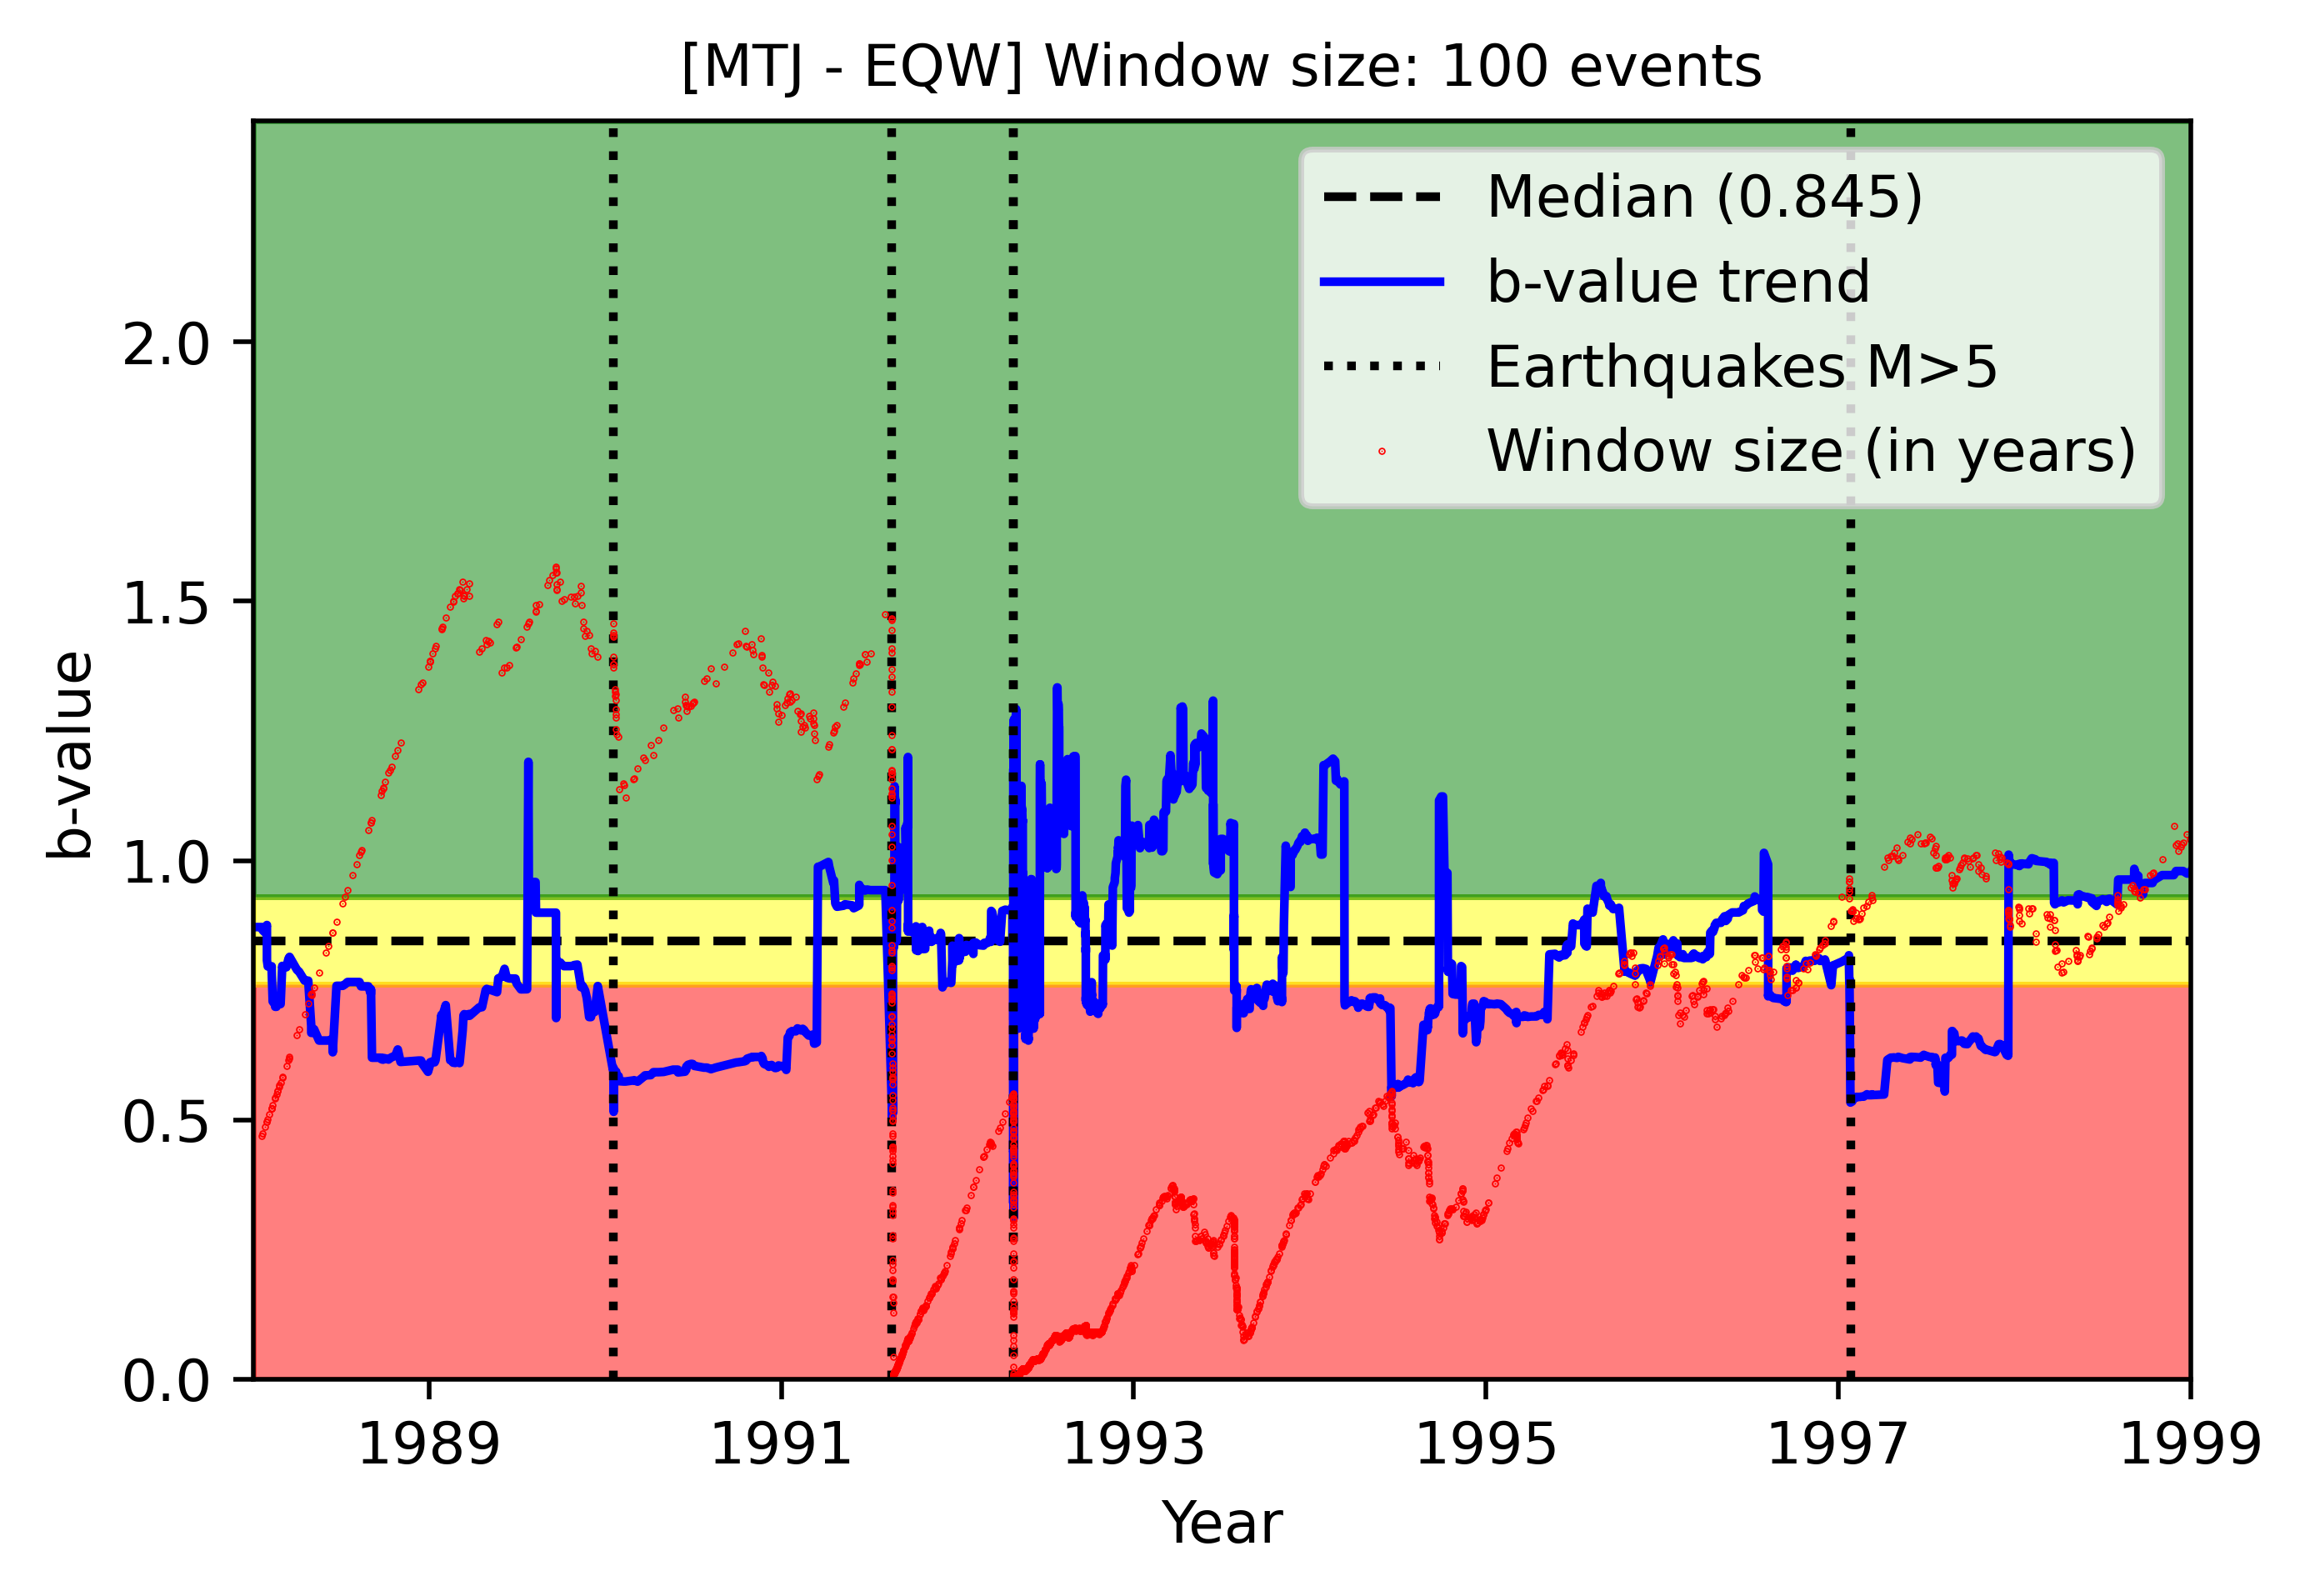

In [27]:
slide = []
bDates = []
ewLens = []

timeStart = np.min(time_year)
timeEnd = np.max(time_year) #or custom decimal year dates
timeTotal = timeEnd - timeStart

areaParams = (dist_along_proj<70)&(dist_along_proj>0)&(dist_norm_proj<5)&(dist_norm_proj>-5)
timeParams = (time_year>timeStart)&(time_year<timeEnd)

bigMag = 5

data = np.where(areaParams&timeParams)
#data = np.where(timeParams&areaParams&(mag<=bigMag))
index = data[0]
print(len(index),index)

ewSize = 100 #number of eqs per window

for i in range(len(index)):

    ew = index[i:i+ewSize] # filter 'ew' by 'wParams'
    ewEnd = time_year[ew][-1]
    bDates.append(time_year[ew[-1]]) # append last event date in 'ew'. Provided by ChatGPT

    bEW = calc_Mc_b(mag[ew])[2]
    addbVal_slide(slide,bEW,bDates)

    ewLens.append((np.max(time_year[ew])-np.min(time_year[ew])))

    if ew[-1] >= max(index):
        print(f"end of loop, steps: {i}; date of last eq: {ew[-1]}; last b: {bEW}")
        xMin = np.min(bDates)
        xMax = np.max(bDates)
        print(f"x range: {xMin} to {xMax}; array lengths: {len(slide),len(bDates)}")
        addbVal_slide(slide,bEW,bDates,xMin,xMax,1)
        break

bigEqs = np.where(areaParams&timeParams&(mag>bigMag))
bigDates = time_year[bigEqs]

for x in bigDates:
    if x == min(bigDates):
        plt.axvline(x, color='black', linestyle=':',label=f'Earthquakes M>{bigMag}')
    plt.axvline(x, color='black', linestyle=':')

plt.plot(bDates,ewLens,"r.",markersize=0.5,label="Window size (in years)")
plt.title(f"[MTJ - EQW] Window size: {ewSize} events",fontsize=10)
plt.xlim(1988,1999)
plt.legend()